In [1]:

import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import os
import sys
os.chdir('../')
sys.path.append('./')
os.getcwd()
from model import DeepJSCC
import matplotlib.pyplot as plt
import matplotlib
from utils import get_psnr, image_normalization

### Eval para

In [2]:
channel = 'AWGN'
saved = '/home/chun/Deep-JSCC-PyTorch/out/checkpoints/CIFAR10_20_19.0_0.17_AWGN_13h21m38s_on_Jun_02_2024/epoch_999.pkl'

snr = 2000
test_image_dir = './demo/kodim08.png'
times = 10

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
test_image = Image.open(test_image_dir)
test_image.load()
test_image = transform(test_image)

### Trans from nn.DataParallel to nn.Module

In [4]:
state_dict = torch.load(saved)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','') # remove `module.`
    new_state_dict[name] = v
# model.load_state_dict(torch.load(saved))


### Load model from checkpoint

In [5]:


file_name = os.path.basename(os.path.dirname(saved))
c = file_name.split('_')[1]
c = int(c)
model = DeepJSCC(c=c, channel_type=channel, snr=snr)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(new_state_dict)
model.change_channel(channel, snr)

### Eval for times

average psnr is 11.502424621582032 for 10 times on kodim08.png


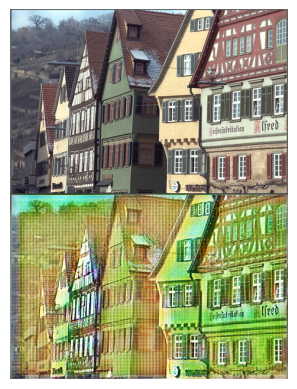

In [6]:
psnr_all = 0.0
with torch.no_grad():

    for i in range(times):
        demo_image = model(test_image)
        demo_image = image_normalization('denormalization')(demo_image)
        gt = image_normalization('denormalization')(test_image)
        psnr_all += get_psnr(demo_image, gt)
    demo_image = image_normalization('normalization')(demo_image)
    demo_image = torch.cat([test_image, demo_image], dim=1)
    demo_image = demo_image.numpy()
plt.imshow(demo_image.transpose(1, 2, 0))
plt.axis('off')
print("average psnr is {} for {} times on {}".format( psnr_all.item() / times, times, os.path.basename(test_image_dir)))

